In [72]:
import os
import pandas as pd
import re
from datetime import datetime
import matplotlib.pyplot as plt

# Set the path to the folder containing the 23andMe files
folder_path = "../../../Data/23andMe_files"

# Read the PRS313 file
PRS313 = pd.read_excel('../../../Data/PRS313.xlsx')

# Read the reference 23andMe genome file
reference_file = "genome_Chad_Wrye_v5_Full_20220921063742.txt"
reference_file_path = os.path.join(folder_path, reference_file)

# Read the reference file into a DataFrame
reference_23andMe_Genome = pd.read_csv(reference_file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])

# Initialize a dictionary to store the results
result_dict = {}

# Initialize a set to store the unique positions from all 23andMe files
unique_positions_set = set()

# Initialize a dictionary to store the counts of positions from each 23andMe file
position_counts = {}

# Iterate over each file in the folder
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    try:
        # Read the first line of the 23andMe raw data file
        with open(file_path, 'r') as file:
            first_line = file.readline()

        # Extract the date and company information from the first line
        date_match = re.search(r"# This data file generated by 23andMe at: (.*)", first_line)
        company_match = re.search(r"# This data file generated by (.*) at:", first_line)

        if date_match and company_match:
            date_str = date_match.group(1)
            company = company_match.group(1)

            # Parse the date string
            date = datetime.strptime(date_str, "%a %b %d %H:%M:%S %Y")

            # Check if the file is from 23andMe and generated after January 1st, 2022
            if company != "23andMe" or date < datetime(2022, 1, 1):
                print(f"File {filename} is not from 23andMe or generated before January 1st, 2022. Deleting the file.")
                os.remove(file_path)
                continue
        else:
            print(f"File {filename} does not contain the required date or company information. Deleting the file.")
            os.remove(file_path)
            continue

        # Read the 23andMe raw data into a DataFrame
        ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])

        # If the number of positions is greater than 700000 or less than 600000, delete the file and move on
        if (ttAndMe.shape[0] > 700000 or ttAndMe.shape[0] < 600000):
            print(f"File {filename} has an invalid number of positions: {ttAndMe.shape[0]}. Deleting the file.")
            os.remove(file_path)
            continue
        ttAndMe['chromosome'] = ttAndMe['chromosome'].astype(str)
        ttAndMe['position'] = ttAndMe['position'].astype(int)

        PRS313['Chromosome'] = PRS313['Chromosome'].astype(str)
        PRS313['Positionb'] = PRS313['Positionb'].astype(int)

        # Merge the 23andMe DataFrame with the PRS313 DataFrame based on chromosome and position
        merged_df = pd.merge(ttAndMe, PRS313[['SNPa', 'Chromosome', 'Positionb']], left_on=['chromosome', 'position'], right_on=['Chromosome', 'Positionb'], how='inner')

        # Count the presence of each SNP in the merged DataFrame
        snp_presence = merged_df.groupby('SNPa').size().reindex(PRS313['SNPa'], fill_value=0).astype(bool)

        # Count the total number of SNPs present
        total_snps_present = snp_presence.sum()

        # Check if at least 60% of the SNPs are in common with the reference 23andMe genome
        reference_snps = set(reference_23andMe_Genome['rsid'])
        file_snps = set(ttAndMe['rsid'])
        common_snps = reference_snps.intersection(file_snps)
        percentage_common_snps = len(common_snps) / len(reference_snps) * 100

        if percentage_common_snps < 60:
            print(f"File {filename} has less than 60% of SNPs in common with the reference 23andMe genome. Deleting the file.")
            os.remove(file_path)
            continue

        # Count the total number of positions in the 23andMe file
        total_positions = ttAndMe.shape[0]

        # Store the results in the dictionary
        result_dict[filename] = list(snp_presence) + [total_snps_present, total_positions]

        # Update the unique positions set
        unique_positions_set.update(zip(ttAndMe['chromosome'], ttAndMe['position']))

        # Update the position counts dictionary
        for pos in zip(ttAndMe['chromosome'], ttAndMe['position']):
            position_counts[pos] = position_counts.get(pos, 0) + 1

    except Exception as e:
        print(f"Error processing file {filename}: {e}")
        os.remove(file_path)
        continue

# Create the result DataFrame from the dictionary
result_df = pd.DataFrame.from_dict(result_dict, orient='index', columns=PRS313['SNPa'].tolist() + ['total_snps_present', 'total_positions'])

# Add row at the end of the result_df that sums up all the True values
# Adding a row at the end that sums up the number of true values in each column
summary = pd.DataFrame(result_df.sum()).T
summary.index = ['Total Number of 23andMe Files containing the SNP']

# Concatenating the summary row to the dataframe
result_df = pd.concat([result_df, summary])

# Save the results to Excel files
result_df.to_excel('../../../Data/23andMe_metadata_files/PRS313_23andMe_PRS313_intersection.xlsx', index_label='filename')

# Create a DataFrame of unique positions excluding those in PRS313
prs313_positions_set = set(zip(PRS313['Chromosome'], PRS313['Positionb']))
unique_positions_excluding_prs313 = unique_positions_set - prs313_positions_set
unique_positions_df = pd.DataFrame(list(unique_positions_excluding_prs313), columns=['chromosome', 'position'])

# Save the unique positions DataFrame to an Excel file
unique_positions_df.to_csv('../../../Data/23andMe_metadata_files/unique_positions_excluding_PRS313.csv', index=False)


/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_46917/756750934.py:18: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  reference_23andMe_Genome = pd.read_csv(reference_file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_46917/756750934.py:59: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_46917/756750934.py:59: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ttAndMe = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['rsid', 'chromosome', 'position', 'genotype'])
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipy

In [32]:
import pandas as pd

dat = pd.read_excel("../../../Data/PRS313_with_23andMe.xlsx")

result_df = pd.read_excel('../../../Data/23andMe_metadata_files/PRS313_23andMe_PRS313_intersection.xlsx', index_col=0)
unique_positions_df = pd.read_csv('../../../Data/23andMe_metadata_files/23andMeGenePanel.csv')

len(unique_positions_df)

0

/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_46917/97938660.py:25: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  bar_plot = sns.barplot(x=count_data.index, y=count_data.values, palette='coolwarm', saturation=0.75, ci=None)
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_46917/97938660.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x=count_data.index, y=count_data.values, palette='coolwarm', saturation=0.75, ci=None)


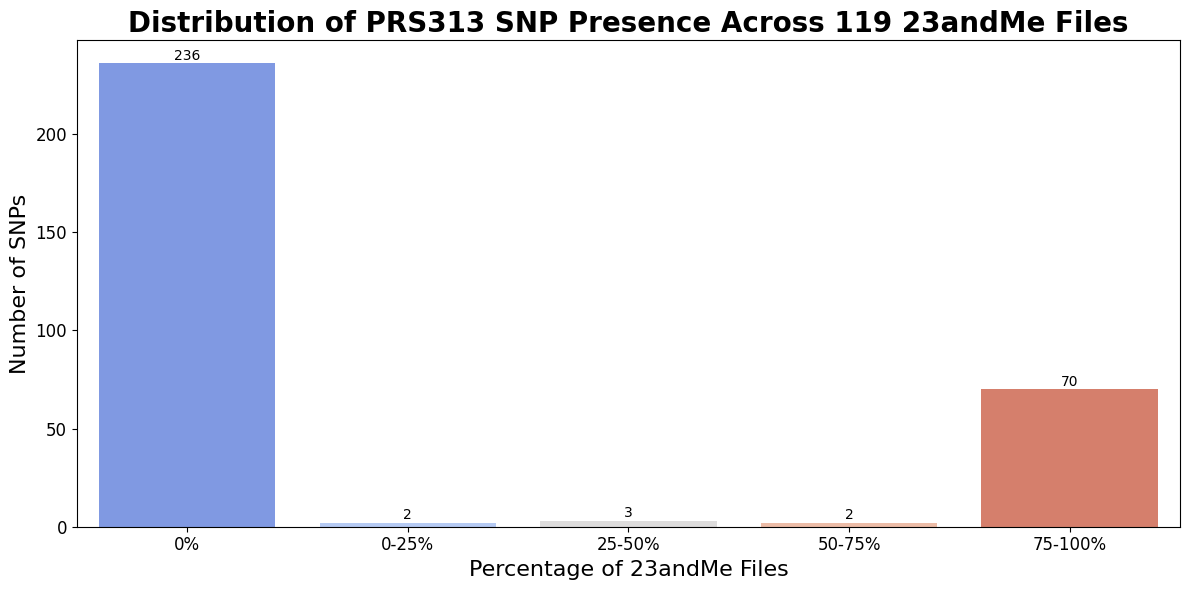

In [84]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming `boxplot_data` is created as follows:
boxplot_data = pd.DataFrame({
    'SNP': PRS313['SNPa'],
    'Presence': result_df.loc['Total Number of 23andMe Files containing the SNP'][:-2]
})

# Calculate the percentage of files each SNP is present in
total_files = len(result_df) - 1  # Exclude the summary row
boxplot_data['Presence_Percentage'] = (boxplot_data['Presence'] / total_files) * 100

# Create bins for the percentage ranges including 0%
bins = [-1, 0.00000001, 25, 50, 75, 100]
labels = ['0%', '0-25%', '25-50%', '50-75%', '75-100%']
boxplot_data['Percentage_Range'] = pd.cut(boxplot_data['Presence_Percentage'], bins=bins, labels=labels, include_lowest=True)

# Count the number of SNPs in each percentage range
count_data = boxplot_data['Percentage_Range'].value_counts().sort_index()

# Plot the bar plot with improved design
plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(x=count_data.index, y=count_data.values, palette='coolwarm', saturation=0.75, ci=None)
plt.title('Distribution of PRS313 SNP Presence Across 119 23andMe Files', fontsize=20, weight='bold')
plt.xlabel('Percentage of 23andMe Files', fontsize=16)
plt.ylabel('Number of SNPs', fontsize=16)

# Adjust bar width by setting the width parameter in barplot
for bar in bar_plot.patches:
    bar.set_width(0.8)  # Reduce bar width

# Add labels on top of each bar
for i in range(len(count_data)):
    bar_plot.text(i, count_data.values[i] + 0.3, count_data.values[i], ha='center', va='bottom', fontsize=10, color='black')

# Improve layout
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


In [34]:
output_folder = "../../Data/23andMe_metadata_files/"

os.makedirs(output_folder, exist_ok=True)

# Create a DataFrame with unique positions
unique_positions_df = pd.DataFrame(list(unique_positions_set), columns=['chromosome', 'position'])
unique_positions_df = unique_positions_df.astype(str)

unique_positions_df.to_parquet(f'{output_folder}23andMe_unique_positions.parquet', index=False)

# Find the positions present in all 23andMe files
num_files = len(result_dict)
intersection_positions_100 = [pos for pos, count in position_counts.items() if count == num_files]
intersection_positions_95 = [pos for pos, count in position_counts.items() if count > 0.95 * num_files]
intersection_positions_90 = [pos for pos, count in position_counts.items() if count > 0.9 * num_files]
intersection_positions_85 = [pos for pos, count in position_counts.items() if count > 0.85 * num_files]
intersection_positions_80 = [pos for pos, count in position_counts.items() if count > 0.8 * num_files]
intersection_positions_75 = [pos for pos, count in position_counts.items() if count > 0.75 * num_files]
intersection_positions_70 = [pos for pos, count in position_counts.items() if count > 0.7 * num_files]
intersection_positions_65 = [pos for pos, count in position_counts.items() if count > 0.65 * num_files]
intersection_positions_60 = [pos for pos, count in position_counts.items() if count > 0.65 * num_files]


intersection_positions_df_100 = pd.DataFrame(intersection_positions_100, columns=['chromosome', 'position']).astype(str)
intersection_positions_df_95 = pd.DataFrame(intersection_positions_95, columns=['chromosome', 'position']).astype(str)
intersection_positions_df_90 = pd.DataFrame(intersection_positions_90, columns=['chromosome', 'position']).astype(str)
intersection_positions_df_85 = pd.DataFrame(intersection_positions_85, columns=['chromosome', 'position']).astype(str)
intersection_positions_df_80 = pd.DataFrame(intersection_positions_80, columns=['chromosome', 'position']).astype(str)
intersection_positions_df_75 = pd.DataFrame(intersection_positions_75, columns=['chromosome', 'position']).astype(str)
intersection_positions_df_70 = pd.DataFrame(intersection_positions_70, columns=['chromosome', 'position']).astype(str)
intersection_positions_df_65 = pd.DataFrame(intersection_positions_65, columns=['chromosome', 'position']).astype(str)
intersection_positions_df_60 = pd.DataFrame(intersection_positions_60, columns=['chromosome', 'position']).astype(str)

# Save the intersection positions to Excel files

intersection_positions_df_100.to_parquet(f'{output_folder}23andMe_intersection_positions_100.parquet', index=False)
intersection_positions_df_95.to_parquet(f'{output_folder}23andMe_intersection_positions_95.parquet', index=False)
intersection_positions_df_90.to_parquet(f'{output_folder}23andMe_intersection_positions_90.parquet', index=False)
intersection_positions_df_85.to_parquet(f'{output_folder}23andMe_intersection_positions_85.parquet', index=False)
intersection_positions_df_80.to_parquet(f'{output_folder}23andMe_intersection_positions_80.parquet', index=False)
intersection_positions_df_75.to_parquet(f'{output_folder}23andMe_intersection_positions_75.parquet', index=False)
intersection_positions_df_70.to_parquet(f'{output_folder}23andMe_intersection_positions_70.parquet', index=False)
intersection_positions_df_65.to_parquet(f'{output_folder}23andMe_intersection_positions_65.parquet', index=False)
intersection_positions_df_60.to_parquet(f'{output_folder}23andMe_intersection_positions_60.parquet', index=False)


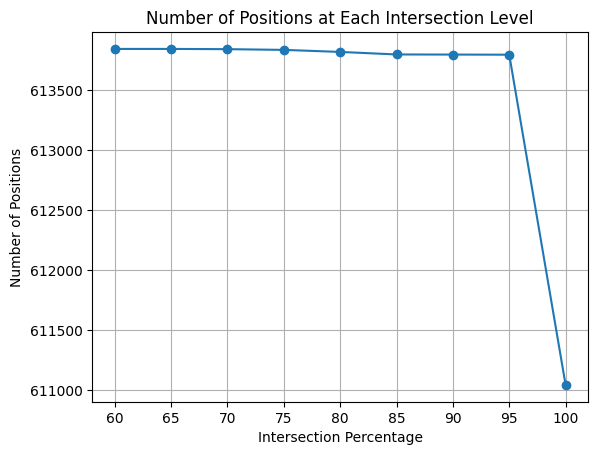

In [9]:
# Graph the number of positions at each intersection level. Plot every 5% from 60% to 100%
import matplotlib.pyplot as plt

intersection_percentages = [60, 65, 70, 75, 80, 85, 90, 95, 100]
intersection_counts = [intersection_positions_df_60.shape[0], intersection_positions_df_65.shape[0], intersection_positions_df_70.shape[0], intersection_positions_df_75.shape[0],
                       intersection_positions_df_80.shape[0], intersection_positions_df_85.shape[0], intersection_positions_df_90.shape[0], intersection_positions_df_95.shape[0], intersection_positions_df_100.shape[0]]

plt.plot(intersection_percentages, intersection_counts, marker='o')
plt.xlabel('Intersection Percentage')
plt.ylabel('Number of Positions')
plt.title('Number of Positions at Each Intersection Level')
plt.grid()
plt.show()

In [10]:
print("Number of unique positions in all 23andMe files:", len(unique_positions_set))

Number of unique positions in all 23andMe files: 663522


# Convert all the 23andMe files to text files

In [36]:
# Set the path to the folder containing the 23andMe files
folder_path = "../../Data/23andMe_files"

# Convert all the 23andMe files to .txt format if they are not already in that format

for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    
    # Check if the file is already in .txt format
    if not filename.endswith('.txt'):
        new_file_path = os.path.join(folder_path, filename + '.txt')
        os.rename(file_path, new_file_path)
        print(f"Renamed {filename} to {filename.split('.')[0] + '.txt'}")
        

Renamed 12102.23andme.9966 to 12102.txt
Renamed 11864.23andme.9744 to 11864.txt
Renamed 11826.23andme.9708 to 11826.txt
Renamed 11703.23andme.9619 to 11703.txt
Renamed 12065.23andme.9923 to 12065.txt
Renamed 11936.23andme.9808 to 11936.txt
Renamed 12299.23andme.10131 to 12299.txt
Renamed 11874.23andme.9752 to 11874.txt
Renamed 12072.23andme.9932 to 12072.txt
Renamed 11662.23andme.9585 to 11662.txt
Renamed 12192.23andme.10043 to 12192.txt
Renamed 11983.23andme.9848 to 11983.txt
Renamed 11775.23andme.9673 to 11775.txt
Renamed 11919.23andme.9794 to 11919.txt
Renamed 11850.23andme.9730 to 11850.txt
Renamed 11765.23andme.9663 to 11765.txt
Renamed 12266.23andme.10102 to 12266.txt
Renamed 12155.23andme.10004 to 12155.txt
Renamed 10936.23andme.9481 to 10936.txt
Renamed 11993.23andme.9860 to 11993.txt
Renamed 12018.23andme.9881 to 12018.txt
Renamed 11919.23andme.9793 to 11919.txt
Renamed 11957.23andme.9826 to 11957.txt
Renamed 11722.23andme.9630 to 11722.txt
Renamed 11654.23andme.9576 to 11654.